In [1]:
import numpy as np
import pandas as pd
import loadData
import monteCarloClass
import time

In [2]:
data, dataName = loadData.loadData("dt_all.csv")

intensityVariable = "deltaDurS"
sensoryVar = "audNoise"
standardVar = "standardDur"
conflictVar = "conflictDur"

visualStandardVar = "unbiasedVisualStandardDur"
visualTestVar = "unbiasedVisualTestDur"
audioStandardVar = "standardDur"
audioTestVar = "testDurS"


 Total trials before cleaning
: 2226
uniqueSensory: [0.1 1.2] 
 uniqueStandard: [0.5] 
 uniqueConflict: [-0.25, -0.17, -0.08, 0.0, 0.08, 0.17, 0.25]

0  trials with testDurSCheck False
0  trials with standardDurCheck False

0  trials with abs(testDurSCompare) > 0.05
0  trials with abs(standardDurCompare) > 0.05

0  trials with testDurSCheckBias False
0  trials with negative visual test duration
0  trials with negative visual standard duration
testdurCompare > 0.05: 0 trials
0  trials with negative visual standard duration
0  trials with negative visual test duration
total trials after cleaning: 2226


In [3]:
data

,Unnamed: 0,standardDur,audNoise,order,preDur,postDur,isiDur,trial_num,totalDur,delta_dur_percents,...,standardDurCheck,testDurSCompare,standardDurCompare,standard_dur,riseDur,logStandardDur,logConflictDur,logTestDur,logDeltaDur,logDeltaDurMs
0,0.0,0.5,0.1,1.0,0.22509,0.29178,0.86700,0.0,2.09247,-0.59,...,True,0.00139,0.0014,0.5,1,-0.693147,-1.386294,-1.568248,-0.875101,-0.875481
1,1.0,0.5,1.2,1.0,0.23342,0.33346,0.88368,1.0,2.15916,-0.59,...,True,0.00381,0.0037,0.5,1,-0.693147,-inf,-1.568248,-0.875101,-0.875481
2,2.0,0.5,1.2,1.0,0.24176,0.29178,0.52520,2.0,1.76734,-0.59,...,True,0.00331,0.0005,0.5,1,-0.693147,NaN,-1.568248,-0.875101,-0.875481
3,3.0,0.5,1.2,2.0,0.35014,0.43350,0.75863,3.0,2.25087,-0.59,...,True,0.00351,0.0034,0.5,1,-0.693147,-1.386294,-1.568248,-0.875101,-0.875481
4,4.0,0.5,1.2,1.0,0.26677,0.34180,0.40849,4.0,2.46762,0.90,...,True,0.00337,0.0035,0.5,1,-0.693147,-inf,-0.050904,0.642243,0.641863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2486,9.0,0.5,0.1,1.0,0.39640,0.41292,0.55331,9.0,2.81610,0.90,...,True,0.01029,0.0069,0.5,1,-0.693147,NaN,-0.051599,0.641549,0.634057
2487,10.0,0.5,1.2,1.0,0.42118,0.41292,0.49550,10.0,2.12240,-0.42,...,True,0.00084,0.0014,0.5,1,-0.693147,-1.771957,-1.241190,-0.548043,-0.555535
2488,11.0,0.5,0.1,2.0,0.41292,0.28078,0.60286,11.0,2.75003,0.90,...,True,0.01099,0.0067,0.5,1,-0.693147,NaN,-0.051599,0.641549,0.634057
2489,12.0,0.5,0.1,2.0,0.32208,0.39640,0.80932,12.0,2.32060,-0.42,...,True,0.00376,0.0062,0.5,1,-0.693147,-1.771957,-1.241190,-0.548043,-0.555535


In [4]:
# Instantiate the Monte Carlo class
mc_fitter = monteCarloClass.OmerMonteCarlo(data)

In [5]:
mc_fitter.nSimul = 1000
mc_fitter.optimizationMethod= "bads"  # Use BADS for optimization
mc_fitter.nStart = 1 # Number of random starts for optimization
mc_fitter.mDist = "lognorm"  # Set measurement distribution to Gaussian


In [6]:
groupedData = mc_fitter.groupByChooseTest(
    x=data,
    groupArgs=[
        intensityVariable, sensoryVar, standardVar, conflictVar,
        visualStandardVar, visualTestVar, audioTestVar
    ]
)

In [7]:
timeStart = time.time()
print(f"\nFitting Causal Inference Model for {dataName} with {len(groupedData)} unique conditions")
fittedParams = mc_fitter.fitCausalInferenceMonteCarlo(groupedData)
print(f"\nFitted parameters for {dataName}: {fittedParams}")
print(f"Time taken to fit: {time.time() - timeStart:.2f} seconds")
mc_fitter.modelFit= fittedParams


Fitting Causal Inference Model for dt_all with 443 unique conditions

Starting 1 optimization attempts using 'bads'...


Optimization Attempts: 100%|██████████| 1/1 [04:42<00:00, 282.28s/it]


✅ Best result from 1 attempts:
  → Final parameters: [0.24287596 0.20193097 0.39112736 0.57582425 0.52157233 1.69174137]
  → Final log-likelihood: 1269.864862

Fitted parameters for dt_all: [0.24287596 0.20193097 0.39112736 0.57582425 0.52157233 1.69174137]
Time taken to fit: 282.30 seconds


In [8]:
# save the fit results
def saveFitResults(fittedParams, dataName):
    fitResults = pd.DataFrame(fittedParams, index=[0])
    fitResults.to_csv(f"{dataName}_fit_results.csv", index=False)
    print(f"Fit results saved to {dataName}_fit_results.csv")
#saveFitResults(fittedParams, dataName)

import os

def saveFitResults(fittedParams, dataName, participantID):
    """
    Save or update fit results for all participants in a single CSV file.
    
    Args:
        fittedParams (list or array): The fitted parameters to save.
        dataName (str): The name of the dataset.
        participantID (str): The unique identifier for the participant.
    """
    # Define the file name for the results
    results_file = f"{dataName}_fit_results.csv"
    
    # Convert fittedParams to a DataFrame (single row, multiple columns)
    fitResults = pd.DataFrame([fittedParams])
    fitResults['participantID'] = dataName.split('_')[0]  # Add participant ID column
    
    # Check if the file already exists
    if os.path.exists(results_file):
        # Load the existing results
        existing_results = pd.read_csv(results_file)
        
        # Check if the participant's results already exist
        if participantID in existing_results['participantID'].values:
            # Update the existing row for the participant
            mask = existing_results['participantID'] == participantID
            for col in fitResults.columns:
                existing_results.loc[mask, col] = fitResults[col].values[0]
        else:
            # Append the new results
            existing_results = pd.concat([existing_results, fitResults], ignore_index=True)
        
        # Save the updated results
        existing_results.to_csv(results_file, index=False)
    else:
        # Create a new file with the results
        fitResults.to_csv(results_file, index=False)
    
    print(f"Fit results updated in {results_file}")

saveFitResults(mc_fitter.modelFit, dataName, "all")

Fit results updated in dt_all_fit_results.csv


In [9]:
mc_fitter.simulatedData = mc_fitter.simulateMonteCarloData(fittedParams, mc_fitter.data, nSamples=100)
mc_fitter.simDataFit=mc_fitter.fitMultipleStartingPoints(mc_fitter.simulatedData,1)

"psychometric fit"
mc_fitter.dataFit= mc_fitter.fitMultipleStartingPoints(data,1)

Noise: 0.1, Conflict: -0.25, Lambda: 0.243, Sigma_a: 0.202, Sigma_v: 0.391, p_c: 0.576
Noise: 0.1, Conflict: -0.17, Lambda: 0.243, Sigma_a: 0.202, Sigma_v: 0.391, p_c: 0.576
Noise: 0.1, Conflict: -0.08, Lambda: 0.243, Sigma_a: 0.202, Sigma_v: 0.391, p_c: 0.576
Noise: 0.1, Conflict: 0.0, Lambda: 0.243, Sigma_a: 0.202, Sigma_v: 0.391, p_c: 0.576
Noise: 0.1, Conflict: 0.08, Lambda: 0.243, Sigma_a: 0.202, Sigma_v: 0.391, p_c: 0.576
Noise: 0.1, Conflict: 0.17, Lambda: 0.243, Sigma_a: 0.202, Sigma_v: 0.391, p_c: 0.576
Noise: 0.1, Conflict: 0.25, Lambda: 0.243, Sigma_a: 0.202, Sigma_v: 0.391, p_c: 0.576
Noise: 1.2, Conflict: -0.25, Lambda: 0.243, Sigma_a: 0.522, Sigma_v: 0.391, p_c: 0.576
Noise: 1.2, Conflict: -0.17, Lambda: 0.243, Sigma_a: 0.522, Sigma_v: 0.391, p_c: 0.576
Noise: 1.2, Conflict: -0.08, Lambda: 0.243, Sigma_a: 0.522, Sigma_v: 0.391, p_c: 0.576
Noise: 1.2, Conflict: 0.0, Lambda: 0.243, Sigma_a: 0.522, Sigma_v: 0.391, p_c: 0.576
Noise: 1.2, Conflict: 0.08, Lambda: 0.243, Sigma_a

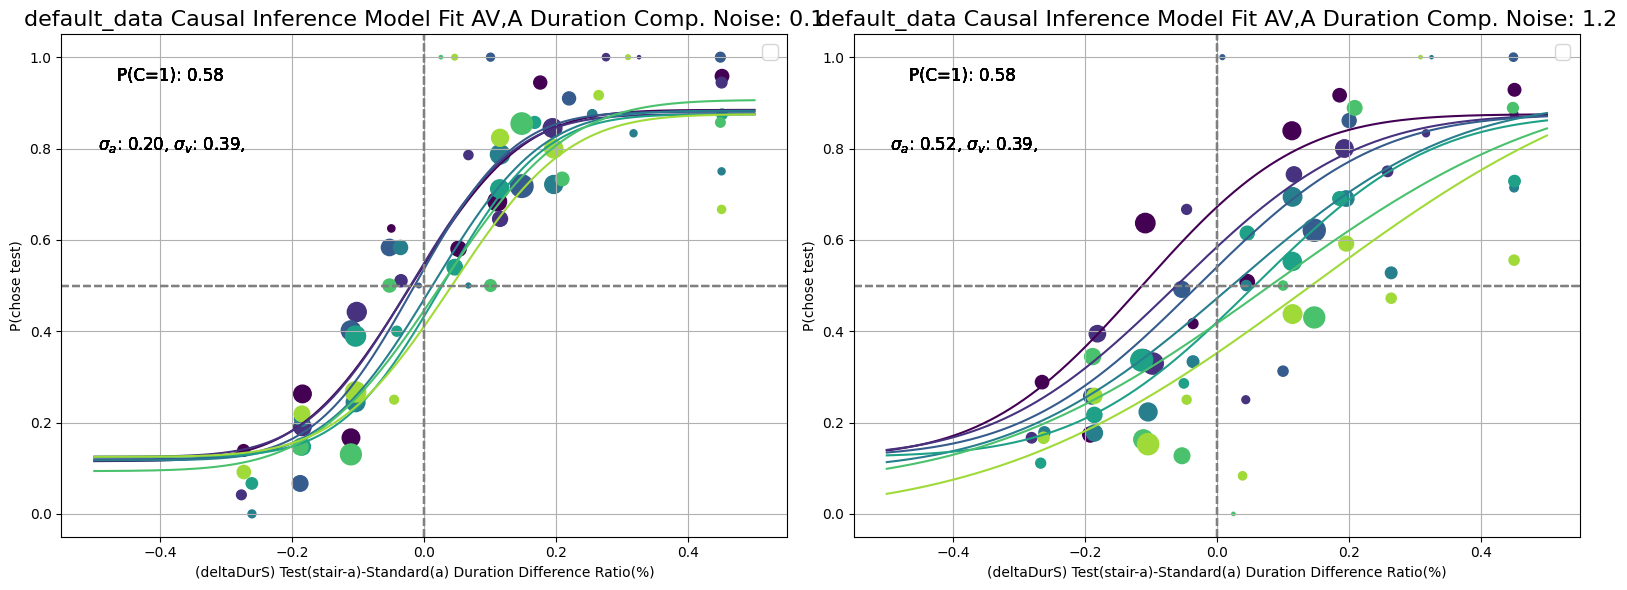

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns
# mc_fitter.dataName = dataName
# mc_fitter.data= data
# mc_fitter.visualStandardVar = visualStandardVar
# mc_fitter.visualTestVar = visualTestVar
# mc_fitter.audioTestVar = audioTestVar

mc_fitter.plotPsychometrics_MC_Data()

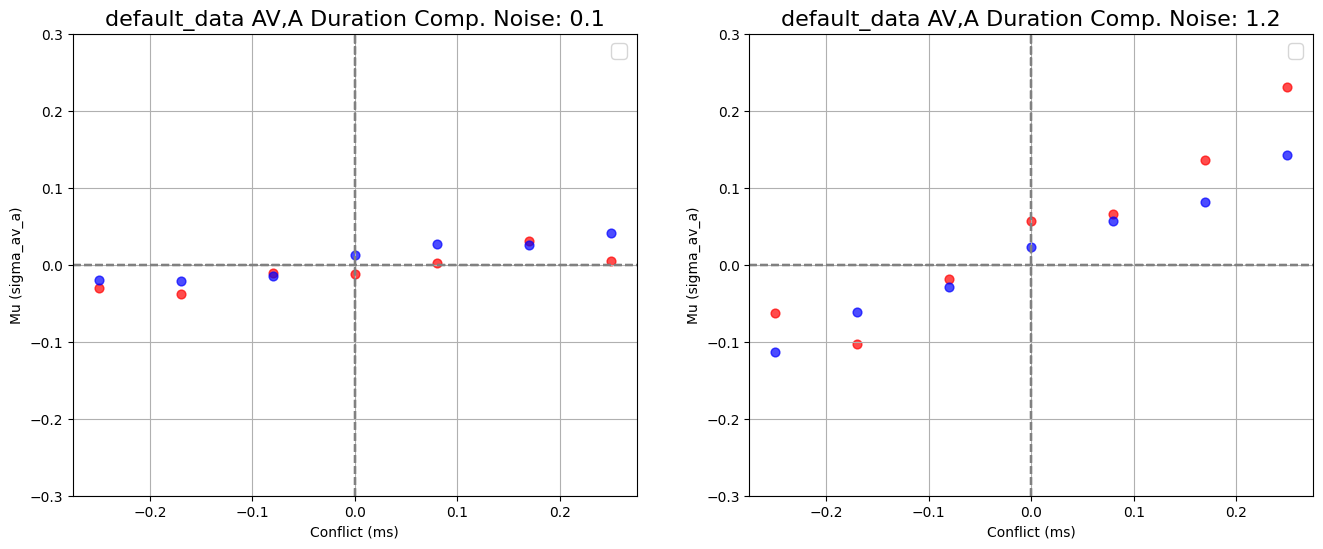

In [12]:

mc_fitter.plot_mu_vs_conflict_MC_vs_Data()

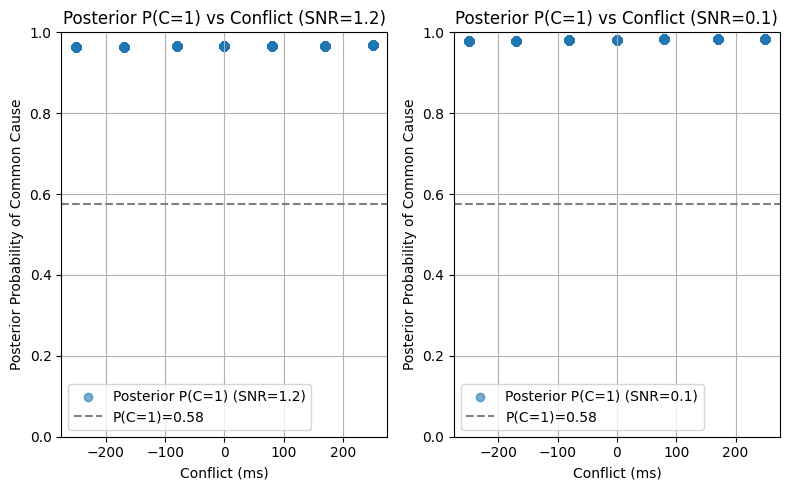

In [13]:
mc_fitter.plot_posterior_vs_conflict(mc_fitter.data, fittedParams)

In [21]:
nSimul_values = [100,500]
results = []
mc_fitter.mDist = "lognorm"  # Set measurement distribution to lognormal

mc_fitter.nStart = 1  # Number of random starts for optimization
mc_fitter.optimizationMethod = "bads"  # Use BADS for optimization
for nSimul in nSimul_values:
    mc_fitter.nSimul = nSimul
    fittedParams = mc_fitter.fitCausalInferenceMonteCarlo(groupedData)
    log_likelihood = -mc_fitter.nLLMonteCarloCausal(fittedParams, groupedData)
    results.append((nSimul, fittedParams, log_likelihood))

# Compare results
for nSimul, params, ll in results:
    print(f"nSimul: {nSimul}, Log-Likelihood: {ll:.4f}, Params: {params}")


Starting 1 optimization attempts using 'bads'...


Optimization Attempts:   0%|          | 0/1 [00:00<?, ?it/s]

bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.


Optimization Attempts: 100%|██████████| 1/1 [00:36<00:00, 36.86s/it]



✅ Best result from 1 attempts:
  → Final parameters: [0.24299005 0.19013137 0.4515798  0.05       0.51615853 0.30875064
 0.05      ]
  → Final log-likelihood: 1275.584340

Starting 1 optimization attempts using 'bads'...


Optimization Attempts:   0%|          | 0/1 [00:00<?, ?it/s]

bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.


Optimization Attempts: 100%|██████████| 1/1 [01:04<00:00, 64.62s/it]


✅ Best result from 1 attempts:
  → Final parameters: [0.29999924 0.16833697 0.42034334 0.05       0.43260689 0.98930159
 0.98751372]
  → Final log-likelihood: 1269.776819
nSimul: 100, Log-Likelihood: -1273.3691, Params: [0.24299005 0.19013137 0.4515798  0.05       0.51615853 0.4515798
 0.05      ]
nSimul: 500, Log-Likelihood: -1269.7878, Params: [0.29999924 0.16833697 0.42034334 0.05       0.43260689 0.42034334
 0.98751372]


In [ ]:
def calculate_mu_from_data_and_model(data, fittedParams):
	"""
	Calculate mu (PSE) from both data and model predictions for each SNR and conflict condition.
	"""
	# Get unique conditions
	unique_snr = sorted(data['audNoise'].unique())
	unique_conflict = sorted(data['conflictDur'].unique())
	
	mu_data = {}
	mu_model = {}
	
	# Calculate mu for each condition
	for snr in unique_snr:
		mu_data[snr] = {}
		mu_model[snr] = {}
		
		for conflict in unique_conflict:
			# Filter data for current condition
			condition_data = data[(data['audNoise'] == snr) & (data['conflictDur'] == conflict)]
			
			if len(condition_data) > 0:
				# Group data by delta duration
				grouped = condition_data.groupby('deltaDurS').agg({
					'chose_test': 'sum',
					'responses': 'count'
				}).reset_index()
				grouped['p_choose_test'] = grouped['chose_test'] / grouped['responses']
				
				# Fit psychometric function to get mu from data
				if len(grouped) > 3:  # Need enough points to fit
					try:
						# Estimate initial guesses
						init_guess = estimate_initial_guesses(
							grouped['deltaDurS'].values,
							grouped['chose_test'].values,
							grouped['responses'].values
						)
						
						# Fit psychometric function
						fitted_params_data = fit_psychometric_function(
							grouped['deltaDurS'].values,
							grouped['chose_test'].values,
							grouped['responses'].values,
							init_guess
						)
						mu_data[snr][conflict] = fitted_params_data[1]  # mu is second parameter
						
					except:
						mu_data[snr][conflict] = np.nan
				else:
					mu_data[snr][conflict] = np.nan
				
				# Get mu from causal inference model
				lambda_, sigma_av_a, sigma_av_v, p_c = getParamsCausal(fittedParams, conflict, snr)
				
				# Calculate model's effective mu by finding where P(choose test) = 0.5
				delta_range = np.linspace(-0.5, 0.5, 1000)
				p_values = []
				
				for delta in delta_range:
					p = probTestLonger_vectorized(delta, conflict, lambda_, sigma_av_a, sigma_av_v, p_c)
					p_values.append(p)
				
				p_values = np.array(p_values)
				# Find delta where p is closest to 0.5
				idx_closest = np.argmin(np.abs(p_values - 0.5))
				mu_model[snr][conflict] = delta_range[idx_closest]
			
			else:
				mu_data[snr][conflict] = np.nan
				mu_model[snr][conflict] = np.nan
	
	return mu_data, mu_model

def plot_mu_comparison(mu_data, mu_model, unique_snr, unique_conflict):
	"""
	Plot comparison of mu values from data vs model predictions.
	"""
	fig, axes = plt.subplots(1, 2, figsize=(15, 6))
	
	colors = sns.color_palette("viridis", n_colors=len(unique_conflict))
	
	for i, snr in enumerate(unique_snr):
		ax = axes[i]
		
		conflicts_plot = []
		mu_data_plot = []
		mu_model_plot = []
		
		for j, conflict in enumerate(unique_conflict):
			if not np.isnan(mu_data[snr][conflict]) and not np.isnan(mu_model[snr][conflict]):
				conflicts_plot.append(conflict * 1000)  # Convert to ms
				mu_data_plot.append(mu_data[snr][conflict] * 1000)  # Convert to ms
				mu_model_plot.append(mu_model[snr][conflict] * 1000)  # Convert to ms
		
		if conflicts_plot:
			# Plot data mu
			ax.scatter(conflicts_plot, mu_data_plot, 
					  color='red', s=100, alpha=0.7, 
					  label='Data μ (PSE)', marker='o')
			
			# Plot model mu
			ax.scatter(conflicts_plot, mu_model_plot, 
					  color='blue', s=100, alpha=0.7, 
					  label='Model μ (PSE)', marker='s')
			
			# Connect corresponding points
			for k in range(len(conflicts_plot)):
				ax.plot([conflicts_plot[k], conflicts_plot[k]], 
					   [mu_data_plot[k], mu_model_plot[k]], 
					   'gray', alpha=0.5, linestyle='--')
		
		ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
		ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
		ax.set_xlabel('Visual Conflict (ms)')
		ax.set_ylabel('μ (PSE) (ms)')
		ax.set_title(f'Data vs Model μ (SNR={snr})')
		# limits
		ax.set_ylim(-300, 300)
		ax.legend()
		ax.grid(True, alpha=0.3)
	
	plt.tight_layout()
	plt.show()
	
	# Print numerical comparison
	print("\n=== Mu (PSE) Comparison: Data vs Model ===")
	print("SNR\tConflict(ms)\tData μ(ms)\tModel μ(ms)\tDifference(ms)")
	print("-" * 60)
	
	for snr in unique_snr:
		for conflict in unique_conflict:
			if not np.isnan(mu_data[snr][conflict]) and not np.isnan(mu_model[snr][conflict]):
				data_mu_ms = mu_data[snr][conflict] * 1000
				model_mu_ms = mu_model[snr][conflict] * 1000
				diff_ms = data_mu_ms - model_mu_ms
				print(f"{snr}\t{conflict*1000:.0f}\t\t{data_mu_ms:.2f}\t\t{model_mu_ms:.2f}\t\t{diff_ms:.2f}")

def plot_mu_vs_conflict_detailed(mu_data, mu_model, unique_snr, unique_conflict):
	"""
	Create a more detailed plot showing mu vs conflict with trend lines.
	"""
	plt.figure(figsize=(12, 8))
	
	for i, snr in enumerate(unique_snr):
		plt.subplot(2, 2, i+1)
		
		conflicts_ms = []
		mu_data_ms = []
		mu_model_ms = []
		
		for conflict in unique_conflict:
			if not np.isnan(mu_data[snr][conflict]) and not np.isnan(mu_model[snr][conflict]):
				conflicts_ms.append(conflict * 1000)
				mu_data_ms.append(mu_data[snr][conflict] * 1000)
				mu_model_ms.append(mu_model[snr][conflict] * 1000)
		
		if conflicts_ms:
			# Plot with trend lines
			plt.plot(conflicts_ms, mu_data_ms, 'ro-', linewidth=2, markersize=8, 
					label='Data μ', alpha=0.8)
			plt.plot(conflicts_ms, mu_model_ms, 'bs-', linewidth=2, markersize=8, 
					label='Model μ', alpha=0.8)
			
			# Calculate correlation
			if len(conflicts_ms) > 2:
				corr_data = np.corrcoef(conflicts_ms, mu_data_ms)[0,1]
				corr_model = np.corrcoef(conflicts_ms, mu_model_ms)[0,1]
				plt.text(0.05, 0.95, f'Data r={corr_data:.3f}\nModel r={corr_model:.3f}', 
						transform=plt.gca().transAxes, fontsize=10,
						verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
		
		plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
		plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
		plt.xlabel('Visual Conflict (ms)')
		plt.ylabel('μ (PSE) (ms)')
		plt.title(f'μ vs Conflict (SNR={snr})')
		plt.legend()
		plt.grid(True, alpha=0.3)
		plt.ylim(-300, 300)
	
	# Correlation plot
	plt.subplot(2, 2, len(unique_snr)+1)
	all_data_mu = []
	all_model_mu = []
	
	for snr in unique_snr:
		for conflict in unique_conflict:
			if not np.isnan(mu_data[snr][conflict]) and not np.isnan(mu_model[snr][conflict]):
				all_data_mu.append(mu_data[snr][conflict] * 1000)
				all_model_mu.append(mu_model[snr][conflict] * 1000)
	
	if all_data_mu:
		plt.scatter(all_data_mu, all_model_mu, s=100, alpha=0.7)
		
		# Add diagonal line (perfect correlation)
		min_val = min(min(all_data_mu), min(all_model_mu))
		max_val = max(max(all_data_mu), max(all_model_mu))
		plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect correlation')
		
		# Calculate overall correlation
		overall_corr = np.corrcoef(all_data_mu, all_model_mu)[0,1]
		plt.text(0.05, 0.95, f'Overall r={overall_corr:.3f}', 
				transform=plt.gca().transAxes, fontsize=12,
				verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
		
		plt.xlabel('Data μ (ms)')
		plt.ylabel('Model μ (ms)')
		plt.title('Data vs Model μ Correlation')
		plt.legend()
		plt.grid(True, alpha=0.3)
		plt.ylim(-300, 300)
	
	plt.tight_layout()
	plt.show()

# Calculate mu from both data and model
print("Calculating mu (PSE) from data and model predictions...")
mu_data, mu_model = calculate_mu_from_data_and_model(data, fittedParams)

# Get unique values for plotting
unique_snr = sorted(data['audNoise'].unique())
unique_conflict = sorted(data['conflictDur'].unique())

# Create comparison plots
plot_mu_comparison(mu_data, mu_model, unique_snr, unique_conflict)
plot_mu_vs_conflict_detailed(mu_data, mu_model, unique_snr, unique_conflict)

Calculating mu (PSE) from data and model predictions...


NameError: name 'probTestLonger_vectorized' is not defined